In [21]:
import sys
import cantera as ct
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

import phases
import feedstock as fs
import fuel as fu
import energy as en
import gasifier as gs

In [22]:
ultimate = [46.76, 5.76, 45.83, 0.22, 0.67, 0] # %m/m, dry basis
moistWB = 0.1245 # fraction, wet basis
ashWB = 0.0077 # fraction, wet basis
GCV = 17.36 # MJ/kg

moistDB = moistWB / (1 - moistWB)
ashDB = ashWB / (1 - moistWB)

conv = (phases.Pn) * (phases.Mw_air) / (phases.R * phases.Tn)

In [23]:
feedRate = np.array([1.73, 2.15, 2.64, 3.19, 3.69, 4.02, 4.06, 4.48, 4.70, 4.93, 5.40]) # kg/h of wet fuel
airRatio = np.array([1.63, 1.64, 1.52, 1.38, 1.51, 1.46, 1.47, 1.44, 1.37, 1.48, 1.50]) # Nm³/kg
dryFeedRate = (1 - moistWB) * feedRate # kg/h of dry fuel
airFlow = conv * airRatio * feedRate # kg/h of air

In [24]:
H2_exp = np.array([14.77, 14.62, 14.77, 14.77, 14.12, 13.13, 12.67, 11.86, 13.83, 11.33, 11.11])
N2_exp = np.array([58.67, 59.67, 56.96, 57.05, 57.07, 53.33, 54.71, 53.95, 54.24, 55.65, 55.83])
CH4_exp = np.array([1.40, 2.10, 1.94, 2.03, 1.70, 2.18, 1.97, 2.47, 1.98, 2.36, 2.15])
CO_exp = np.array([8.56, 8.92, 12.08, 14.41, 16.80, 20.66, 19.63, 19.89, 18.41, 18.99, 18.56])
CO2_exp = np.array([16.33, 13.92, 13.02, 11.42, 9.93, 9.52, 10.02, 11.25, 11.12, 11.09, 11.22])
gasFlow_exp = np.array([3.55, 4.44, 5.33, 6.22, 7.26, 8.15, 8.15, 9.18, 9.48, 10.07, 10.96]) # Nm³/h
HHV_exp = np.array([3.47, 3.76, 4.22, 4.50, 4.55, 5.12, 4.96, 5.15, 4.75, 4.86, 4.66])

In [ ]:
char_params = np.array([])
methane_params = np.array([])

In [25]:
fuels = []
airs = []
ERs = np.zeros_like(feedRate)
outlets = []

for i, dryFeed in enumerate(dryFeedRate):
    fuel = fs.create_fuel_stream(dryFeed, ultimate, ashDB, moistDB, GCV)
    fuels.append(fuel)
    air = fs.create_air_stream(airFlow[i])
    airs.append(air)
    outlet = gs.gasify_nonisot(fuel, air)
    outlets.append(outlet)
    stoichAir = fs.create_air_from_ER(fuel, 1.0)
    ER = air.get_mass() / stoichAir.get_mass()
    ERs[i] = ER

In [30]:
syngasHHV = np.array([out.get_syngas_hhv(basis='vol', water=False, nitrogen=True) for out in outlets])
syngasFlow = np.array([out.get_syngas_amount(basis='vol', water=False, nitrogen=True) for out in outlets])
H2 = np.array([100*out.get_syngas_fraction(species='H2', water=False, nitrogen=True) for out in outlets])
N2 = np.array([100*out.get_syngas_fraction(species='N2', water=False, nitrogen=True) for out in outlets])
CH4 = np.array([100*out.get_syngas_fraction(species='CH4', water=False, nitrogen=True) for out in outlets])
CO = np.array([100*out.get_syngas_fraction(species='CO', water=False, nitrogen=True) for out in outlets])
CO2 = np.array([100*out.get_syngas_fraction(species='CO2', water=False, nitrogen=True) for out in outlets])
# print(syngasHHV)
# print(syngasFlow)
print(np.average(H2) - np.average(H2_exp))
print(np.average(N2) - np.average(N2_exp))
print(np.average(CH4) - np.average(CH4_exp))
print(np.average(CO) - np.average(CO_exp))
print(np.average(CO2) - np.average(CO2_exp))

4.748746325398493
-7.100556403681466
-2.0157742433215233
3.431749018645718
0.8810318969389748


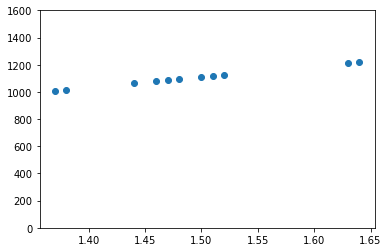

In [27]:
plt.scatter(airRatio, [out.T for out in outlets])
plt.ylim(0, 1600)
plt.show()